In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import(StandardScaler,MinMaxScaler,OneHotEncoder,OrdinalEncoder)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score)
from sklearn.metrics import ConfusionMatrixDisplay

C:\Users\user\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Load the Data

In [2]:
df=pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Check for missing values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Observation:
    1.Age,Embarked and Cabin columns have missing values.

In [4]:
#info about the data
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data Cleaning

In [5]:
#Columns to drop 
columns_to_drop=['PassengerId','Name','Cabin','Ticket']

In [6]:
def clean_data(df):
    return(
    df
    .drop(columns=columns_to_drop)
    .assign(family=lambda df:df['SibSp']+df['Parch'] )
    .drop(columns=['SibSp','Parch']))

In [7]:
final_df=clean_data(df)
final_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [8]:
#shape of the cleaned data
print(f'The cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns')

The cleaned data has 891 rows and 7 columns


In [9]:
#missing values in the cleaned data
(final_df.isna().sum())

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
Embarked      2
family        0
dtype: int64

# EDA

In [10]:
#distribution of target
(final_df['Survived']
 .value_counts(normalize=True))

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [11]:
#boxplots
def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data,y=column_name,hue=hue)

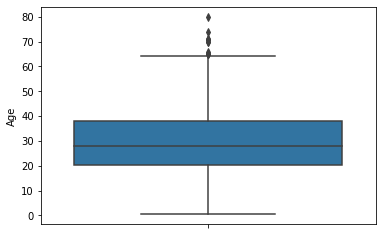

In [12]:
#boxplot for age column
create_boxplot(final_df,'Age')

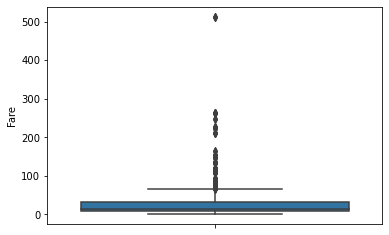

In [13]:
#boxplot for fare column
create_boxplot(final_df,'Fare')

### Overview
  Outliers in the age and fare column

In [14]:
#plot the distribution of Categorical columns
def plot_distribution(data,column_name):
    sns.countplot(data=data,x=column_name)

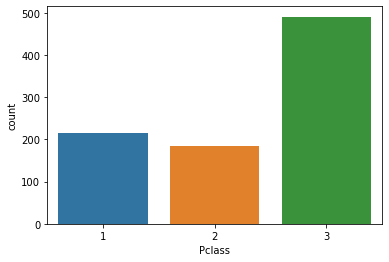

In [15]:
#distribution for pclass
plot_distribution(final_df,'Pclass')

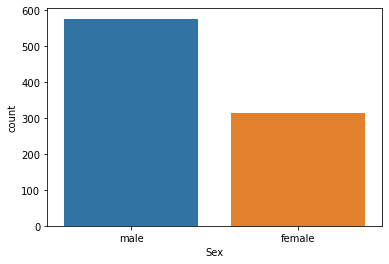

In [16]:
#distribution for sex
plot_distribution(final_df,'Sex')

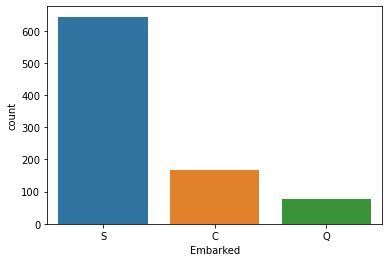

In [17]:
#distribution for embarked
plot_distribution(final_df,'Embarked')

## Feature Engineering

In [18]:
#Make X and y
X=final_df.drop(columns=['Survived'])
y=final_df['Survived']

In [19]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,family
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [20]:
#train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Pipelines for Individual Columns

In [21]:
#age_pipeline
age_pipe=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('outliers',Winsorizer(capping_method='gaussian',fold=3)),#Determine the Capping Limits:

# Lower limit = μ - (fold * σ)
# Upper limit = μ + (fold * σ)
    ('scale',StandardScaler())
])
age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [22]:
#fare pipeline
fare_pipeline=Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('scale',StandardScaler())
])
fare_pipeline

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [23]:
X_train.loc[:,'Embarked'].value_counts()

Embarked
S    525
C    125
Q     60
Name: count, dtype: int64

In [24]:
#Embarked pipeline
embarked_pipeline=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('count_encode',CountFrequencyEncoder(encoding_method='count')),
    ('scale',MinMaxScaler())
])
embarked_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

## Column Transformer

In [25]:
set_config(transform_output='pandas')

In [26]:
#make column transformer
preprocessor=ColumnTransformer(transformers=[
    ('age',age_pipe,['Age']),
    ('fare',fare_pipeline,['Fare']),
    ('embarked',embarked_pipeline,['Embarked']),
    ('sex',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['Sex']),
    ('family',MinMaxScaler(),['family'])],
                               remainder='passthrough',
                               n_jobs=-1,
                               force_int_remainder_cols=False)
preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['Age']),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['Fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['Embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [27]:
#fit and transform the training data
preprocessor.fit_transform(X_train)

,age__Age,fare__Fare,embarked__Embarked,sex__Sex_female,sex__Sex_male,family__family,remainder__Pclass
331,1.266850,0.236751,1.0,0.0,1.0,0.0,1
733,-0.478777,-0.532339,1.0,0.0,1.0,0.0,2
382,0.219474,-0.784153,1.0,0.0,1.0,0.0,3
704,-0.246027,-0.787666,1.0,0.0,1.0,0.1,3
813,-1.797695,0.374443,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...
106,-0.633944,-0.797799,1.0,1.0,0.0,0.0,3
270,-0.090860,0.360798,1.0,0.0,1.0,0.0,1
860,0.917724,-0.477346,1.0,0.0,1.0,0.2,3
435,-1.177028,2.016201,1.0,1.0,0.0,0.3,1


In [28]:
preprocessor.get_params()

{'force_int_remainder_cols': False,
 'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['Age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['Fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['Embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['Sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('outliers', Winsorizer(fold=3)), ('s

## Model Pipeline

In [29]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [30]:
#build the model pipeline
model_params={'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.9,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [31]:
model_pipe=Pipeline(steps=[('preprocessor',preprocessor),
                          ('clf',RandomForestClassifier(**model_params))])
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('sca...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['Embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_samples=0.9, n_jobs=-1,
                                        random_state=30))])

In [32]:
model_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('sca...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['Embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_samples=0.9, n_jobs=-1,
                                        random_state=30))])

In [33]:
#Evaluate the model on the test data
y_pred=model_pipe.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

In [34]:
#metrics dict
metrics={
         'accuracy':accuracy,
         'precision':precision,
          'recall':recall,
          'f1_score':f1}
metrics

{'accuracy': 0.8268156424581006,
 'precision': 0.8028169014084507,
 'recall': 0.7702702702702703,
 'f1_score': 0.7862068965517242}

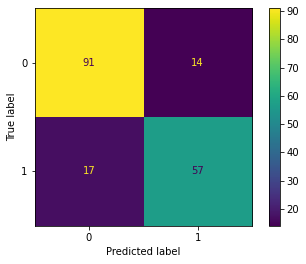

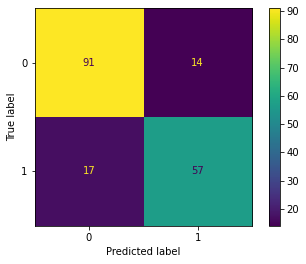

In [35]:
#plot confusion matrix
cm=ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
cm.figure_

In [36]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                     remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='median')),
                                                    ('outliers',
                                                     Winsorizer(fold=3)),
                                                    ('scale', StandardScaler())]),
                                    ['Age']),
                                   ('fare',
                                    Pipeline(steps=[('outliers',
                                                     Winsorizer(capping_method='iqr',
                                                                fold=1.5)),
                                                    ('scale', StandardScaler())]),
                             

In [37]:
mlflow.is_tracking_uri_set()

False

### Run all the mlflow related tracking code in a single cell

In [38]:
#set the tracking uri
mlflow.set_tracking_uri('http://localhost:8000')

#set an experiment name
mlflow.set_experiment('Titanic Data')

#mlflow logging starts
with mlflow.start_run(run_name=
                     'fourth run') as run:
    #log parameters
    mlflow.log_params(model_pipe.get_params())
    
    #log metrics
    mlflow.log_metrics(metrics)
    
    #log models
    mlflow.sklearn.log_model(sk_model=model_pipe,artifact_path='models')
    
    #log confusion matrix
    mlflow.log_figure(cm.figure_,artifact_file='Confusion_matrix.png')
    
    #create mlflow  data
    data=mlflow.data.from_pandas(df=X_train,name='training')
    
    #log the input
    mlflow.log_input(dataset=data,context='training')

C:\Users\user\anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/01 17:06:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/

### Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
mlflow.set_tracking_uri('http://localhost:8000')

#mlflow code to set new experiment 
mlflow.set_experiment('Grid Search')
mlflow.sklearn.autolog()

params_grid={'clf__n_estimators':list(range(100,400,100)),
            'clf__max_depth':list(range(3,11))}

with mlflow.start_run(run_name='parent_run',nested=True) as parent:
    #grid search object
    grid_search=GridSearchCV(estimator=model_pipe,
                            cv=3,
                            param_grid=params_grid,
                            scoring='accuracy',
                            n_jobs=-1)
    #fit the grid search
    grid_search.fit(X_train,y_train)
    
with mlflow.start_run(run_name='best_model') as best:
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric('best_accuracy',grid_search.best_score_)
    mlflow.sklearn.log_model(sk_model=grid_search.best_estimator_,
                            artifact_path='best_model',
                            registered_model_name='Titanic_Random_Forest')

2024/08/02 09:17:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/08/02 09:17:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\u

## HyperOpt

In [42]:
from hyperopt import fmin,tpe,hp,Trials,STATUS_OK

In [43]:
#define the search space
space={
    'n_estimators':hp.quniform('n_estimators', 50,200,10),
    'max_depth':hp.quniform('max_depth',5,20,1),
    'criterion':hp.choice('criterion',['gini','entropy'])
}

In [44]:
def objective(params):
    with mlflow.start_run(nested=True):
        # log the params
        mlflow.log_params(params)
        n_estimators = int(params['n_estimators']) #params is a dict, we extract value from dict
        max_depth = int(params['max_depth'])
        # model object
        model_pipe.named_steps['clf'].set_params(**{'n_estimators':n_estimators,'max_depth':max_depth})
        # model fit
        model_pipe.fit(X_train,y_train)
        # calculate predictions
        y_pred = model_pipe.predict(X_test)
        # calculate accuracy
        accuracy = accuracy_score(y_test,y_pred)
        mlflow.log_metric("accuracy",accuracy)

    return {"loss":-accuracy,"status":STATUS_OK}

The params passed to the objective function are the hyperparameters being tested during the optimization process. They are chosen by the hyperopt library from the specified search space.

Here's how it works:

1. Search Space (space): Defines the range of values for n_estimators and max_depth.
2. Hyperopt: Chooses specific values for these hyperparameters from the search space.
3. Objective Function: Receives these chosen values as params.

For a particular run, it may look like:
params = {'n_estimators': 50, 'max_depth': 10}

In [45]:
mlflow.set_experiment("HP Tuning Hyperopt")

with mlflow.start_run(nested=True):
    # set the fmin function
    trials = Trials()
    
    best = fmin(fn=objective, 
                space=space, 
                algo=tpe.suggest, 
                max_evals=50, 
                trials=trials)

2024/08/02 09:48:52 INFO mlflow.tracking.fluent: Experiment with name 'HP Tuning Hyperopt' does not exist. Creating a new experiment.


  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

2024/08/02 09:48:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:49:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

  2%|▉                                               | 1/50 [00:15<12:54, 15.81s/trial, best loss: -0.8212290502793296]

2024/08/02 09:49:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:49:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

  4%|█▉                                              | 2/50 [00:27<10:41, 13.36s/trial, best loss: -0.8212290502793296]

2024/08/02 09:49:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:49:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

  6%|██▉                                             | 3/50 [00:39<09:54, 12.65s/trial, best loss: -0.8212290502793296]

2024/08/02 09:49:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:49:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

  8%|███▊                                            | 4/50 [00:51<09:43, 12.69s/trial, best loss: -0.8212290502793296]

2024/08/02 09:49:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:49:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 10%|████▊                                           | 5/50 [01:05<09:36, 12.81s/trial, best loss: -0.8212290502793296]

2024/08/02 09:50:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:50:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 12%|█████▊                                          | 6/50 [01:17<09:16, 12.65s/trial, best loss: -0.8212290502793296]

2024/08/02 09:50:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:50:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 14%|██████▋                                         | 7/50 [01:28<08:49, 12.32s/trial, best loss: -0.8212290502793296]

2024/08/02 09:50:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:50:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 16%|███████▋                                        | 8/50 [01:40<08:25, 12.04s/trial, best loss: -0.8212290502793296]

2024/08/02 09:50:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:50:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 18%|████████▋                                       | 9/50 [01:51<08:06, 11.87s/trial, best loss: -0.8212290502793296]

2024/08/02 09:50:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:50:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 20%|█████████▍                                     | 10/50 [02:04<08:09, 12.23s/trial, best loss: -0.8212290502793296]

2024/08/02 09:51:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:51:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 22%|██████████▎                                    | 11/50 [02:17<07:58, 12.28s/trial, best loss: -0.8212290502793296]

2024/08/02 09:51:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:51:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 24%|███████████▎                                   | 12/50 [02:28<07:38, 12.07s/trial, best loss: -0.8212290502793296]

2024/08/02 09:51:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:51:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 26%|████████████▏                                  | 13/50 [02:40<07:16, 11.78s/trial, best loss: -0.8212290502793296]

2024/08/02 09:51:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:51:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 28%|█████████████▏                                 | 14/50 [02:51<07:00, 11.68s/trial, best loss: -0.8212290502793296]

2024/08/02 09:51:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:51:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 30%|██████████████                                 | 15/50 [03:02<06:45, 11.58s/trial, best loss: -0.8212290502793296]

2024/08/02 09:51:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:52:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 32%|███████████████                                | 16/50 [03:14<06:33, 11.58s/trial, best loss: -0.8212290502793296]

2024/08/02 09:52:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:52:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 34%|███████████████▉                               | 17/50 [03:25<06:19, 11.50s/trial, best loss: -0.8268156424581006]

2024/08/02 09:52:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:52:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 36%|████████████████▉                              | 18/50 [03:37<06:08, 11.51s/trial, best loss: -0.8268156424581006]

2024/08/02 09:52:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:52:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 38%|█████████████████▊                             | 19/50 [03:49<05:59, 11.59s/trial, best loss: -0.8268156424581006]

2024/08/02 09:52:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:52:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 40%|██████████████████▊                            | 20/50 [04:01<05:57, 11.93s/trial, best loss: -0.8268156424581006]

2024/08/02 09:52:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:53:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 42%|███████████████████▋                           | 21/50 [04:13<05:42, 11.80s/trial, best loss: -0.8268156424581006]

2024/08/02 09:53:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:53:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 44%|████████████████████▋                          | 22/50 [04:24<05:23, 11.55s/trial, best loss: -0.8268156424581006]

2024/08/02 09:53:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:53:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 46%|█████████████████████▌                         | 23/50 [04:35<05:07, 11.37s/trial, best loss: -0.8268156424581006]

2024/08/02 09:53:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:53:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 48%|██████████████████████▌                        | 24/50 [04:46<04:55, 11.35s/trial, best loss: -0.8268156424581006]

2024/08/02 09:53:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:53:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 50%|███████████████████████▌                       | 25/50 [04:57<04:43, 11.33s/trial, best loss: -0.8268156424581006]

2024/08/02 09:53:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:53:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 52%|████████████████████████▍                      | 26/50 [05:09<04:31, 11.32s/trial, best loss: -0.8268156424581006]

2024/08/02 09:54:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:54:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 54%|█████████████████████████▍                     | 27/50 [05:20<04:18, 11.24s/trial, best loss: -0.8268156424581006]

2024/08/02 09:54:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:54:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 56%|██████████████████████████▎                    | 28/50 [05:34<04:27, 12.18s/trial, best loss: -0.8268156424581006]

2024/08/02 09:54:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:54:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 58%|███████████████████████████▎                   | 29/50 [05:47<04:22, 12.48s/trial, best loss: -0.8268156424581006]

2024/08/02 09:54:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:54:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 60%|████████████████████████████▏                  | 30/50 [06:01<04:19, 12.98s/trial, best loss: -0.8268156424581006]

2024/08/02 09:54:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:55:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 62%|█████████████████████████████▏                 | 31/50 [06:14<04:07, 13.01s/trial, best loss: -0.8268156424581006]

2024/08/02 09:55:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:55:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 64%|██████████████████████████████                 | 32/50 [06:28<03:58, 13.26s/trial, best loss: -0.8268156424581006]

2024/08/02 09:55:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:55:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 66%|███████████████████████████████                | 33/50 [06:41<03:44, 13.22s/trial, best loss: -0.8268156424581006]

2024/08/02 09:55:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:55:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 68%|███████████████████████████████▉               | 34/50 [06:55<03:33, 13.36s/trial, best loss: -0.8268156424581006]

2024/08/02 09:55:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:55:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 70%|████████████████████████████████▉              | 35/50 [07:08<03:19, 13.31s/trial, best loss: -0.8268156424581006]

2024/08/02 09:56:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:56:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 72%|█████████████████████████████████▊             | 36/50 [07:21<03:03, 13.13s/trial, best loss: -0.8268156424581006]

2024/08/02 09:56:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:56:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 74%|██████████████████████████████████▊            | 37/50 [07:33<02:47, 12.90s/trial, best loss: -0.8268156424581006]

2024/08/02 09:56:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:56:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 76%|███████████████████████████████████▋           | 38/50 [07:46<02:34, 12.91s/trial, best loss: -0.8268156424581006]

2024/08/02 09:56:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:56:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 78%|████████████████████████████████████▋          | 39/50 [07:59<02:23, 13.00s/trial, best loss: -0.8268156424581006]

2024/08/02 09:56:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:56:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 80%|█████████████████████████████████████▌         | 40/50 [08:11<02:06, 12.70s/trial, best loss: -0.8268156424581006]

2024/08/02 09:57:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:57:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 82%|██████████████████████████████████████▌        | 41/50 [08:24<01:53, 12.56s/trial, best loss: -0.8268156424581006]

2024/08/02 09:57:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:57:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 84%|███████████████████████████████████████▍       | 42/50 [08:37<01:41, 12.63s/trial, best loss: -0.8268156424581006]

2024/08/02 09:57:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:57:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 86%|████████████████████████████████████████▍      | 43/50 [08:50<01:29, 12.75s/trial, best loss: -0.8268156424581006]

2024/08/02 09:57:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:57:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 88%|█████████████████████████████████████████▎     | 44/50 [09:02<01:16, 12.77s/trial, best loss: -0.8268156424581006]

2024/08/02 09:58:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:58:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 90%|██████████████████████████████████████████▎    | 45/50 [09:19<01:09, 13.94s/trial, best loss: -0.8268156424581006]

2024/08/02 09:58:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:58:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 92%|███████████████████████████████████████████▏   | 46/50 [09:31<00:53, 13.38s/trial, best loss: -0.8268156424581006]

2024/08/02 09:58:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:58:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 94%|████████████████████████████████████████████▏  | 47/50 [09:43<00:39, 13.02s/trial, best loss: -0.8268156424581006]

2024/08/02 09:58:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:58:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 96%|█████████████████████████████████████████████  | 48/50 [09:57<00:26, 13.22s/trial, best loss: -0.8268156424581006]

2024/08/02 09:58:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:58:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

 98%|██████████████████████████████████████████████ | 49/50 [10:10<00:13, 13.04s/trial, best loss: -0.8268156424581006]

2024/08/02 09:59:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/08/02 09:59:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\user\anaconda3\lib\site-packages\mlflow\types\

100%|███████████████████████████████████████████████| 50/50 [10:22<00:00, 12.45s/trial, best loss: -0.8268156424581006]

2024/08/02 09:59:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-whale-225 at: http://localhost:8000/#/experiments/732285412853387917/runs/adf4c0e8aae1487595c3aa358538009a.
2024/08/02 09:59:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8000/#/experiments/732285412853387917.
